In [1]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pickle
import re
import json
import cProfile
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import ray
import numpy as np
import geopandas as geopd
import pandas as pd
import src.data.access as data_access
import src.data.us_specific as us_data
import src.utils.paths as paths_utils
import src.utils.geometry as geo
import src.utils.places_to_cells as places_to_cells
import src.utils.parallel as parallel
import src.data.text_process as text_process
import src.data.word_counts as word_counts
import src.data.clustering as data_clustering
from src.dialects import Region 
from dotenv import load_dotenv
import libpysal
import esda
load_dotenv()

True

In [2]:
paths = paths_utils.ProjectPaths()
source_path_fmt = paths.source_fmt
ext_data_path = paths.ext_data
with open(ext_data_path / 'countries.json') as f:
    countries_dict = json.load(f)
state_fpath = str(paths.shp_file_fmt).format('cb_2018_us_state_5m')
cnty_fpath = str(paths.shp_file_fmt).format('cb_2018_us_county_5m')
us_dict = countries_dict['US']
us_dict['shape_geodf'] = us_data.get_states_geodf(
    state_fpath, xy_proj=countries_dict['US']['xy_proj'])
us_dict['cells_geodf'] = us_data.get_counties_geodf(
    cnty_fpath, us_dict['shape_geodf'],
    xy_proj=countries_dict['US']['xy_proj'])
us_dict['cell_size'] = 'county'

all_cntr_shapes = geopd.read_file(paths.ext_data
                                  / 'CNTR_RG_01M_2016_4326.shp'
                                  / 'CNTR_RG_01M_2016_4326.shp')

In [8]:
lang='fr'
cc = 'CA'
reg_dict = countries_dict['CA']
reg = Region.from_dict(cc, lang, reg_dict)
_ = reg.get_shape_geodf(all_cntr_shapes=all_cntr_shapes)

In [ ]:
all_cc = set()
for f in source_path_fmt.parent.iterdir():
    regex = source_path_fmt.name.format(**{'kind': 'tweets', 'from': '[0-9]{4}', 'to': '[0-9]{4}', 'cc': '([A-Z]{2})'})
    new_cc = re.match(regex, f.name)
    if new_cc:
        all_cc.add(new_cc.groups()[0])
mask = all_cntr_shape_df['FID'].isin(all_cc)
dict(zip(all_cntr_shape_df.loc[mask, 'FID'], all_cntr_shape_df.loc[mask, 'NAME_ENGL']))

{'AO': 'Angola',
 'AG': 'Antigua and Barbuda',
 'AU': 'Australia',
 'BE': 'Belgium',
 'BO': 'Bolivia',
 'BR': 'Brazil',
 'BZ': 'Belize',
 'CA': 'Canada',
 'CG': 'Congo',
 'CH': 'Switzerland',
 'CL': 'Chile',
 'CR': 'Costa Rica',
 'CO': 'Colombia',
 'CM': 'Cameroon',
 'ES': 'Spain',
 'DO': 'Dominican Republic',
 'DZ': 'Algeria',
 'EC': 'Ecuador',
 'EE': 'Estonia',
 'CU': 'Cuba',
 'EG': 'Egypt',
 'CV': 'Cape Verde',
 'CY': 'Cyprus',
 'FR': 'France',
 'FI': 'Finland',
 'HK': 'Hong Kong',
 'HN': 'Honduras',
 'GQ': 'Equatorial Guinea',
 'GT': 'Guatemala',
 'HT': 'Haiti',
 'GW': 'Guinea-Bissau',
 'ID': 'Indonesia',
 'IE': 'Ireland',
 'IN': 'India',
 'IL': 'Israel',
 'LB': 'Lebanon',
 'LT': 'Lithuania',
 'JM': 'Jamaica',
 'LU': 'Luxembourg',
 'LV': 'Latvia',
 'MX': 'Mexico',
 'MY': 'Malaysia',
 'MG': 'Madagascar',
 'NG': 'Nigeria',
 'NI': 'Nicaragua',
 'MA': 'Morocco',
 'MZ': 'Mozambique',
 'PA': 'Panama',
 'PE': 'Peru',
 'PF': 'French Polynesia',
 'PG': 'Papua New Guinea',
 'PK': 'Pakistan',

# Config

In [4]:
paths = paths_utils.ProjectPaths()
with open(paths.ext_data / 'countries.json') as f:
    countries_dict = json.load(f)
all_cntr_shapes = geopd.read_file(paths.ext_data / 'CNTR_RG_01M_2016_4326.shp' / 'CNTR_RG_01M_2016_4326.shp')

In [6]:
num_cpus = 8
min_nr_cells = 3
upper_th = 0.4

In [6]:
params_dict = {'cc': cc, 'kind': 'tweets'}
format_dicts = [{**params_dict, **{'from': m.group('from'), 'to': m.group('to')}}
                for m in paths_utils.yield_paramed_matches(paths.source_fmt, params_dict)]
tweets_files_paths = [
    Path(str(paths.source_fmt).format(**f_dict))
    for f_dict in format_dicts]
places_files_paths = [
    Path(str(paths.source_fmt).format(**{**f_dict, **{'kind': 'places'}}))
    for f_dict in format_dicts]

<AxesSubplot:>

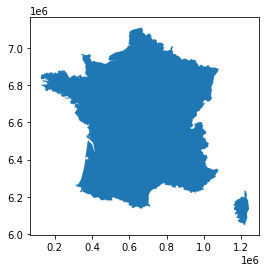

In [8]:
shape_geodf = reg.get_shape_geodf(all_cntr_shapes=all_cntr_shapes)
shape_geodf.plot()

<AxesSubplot:>

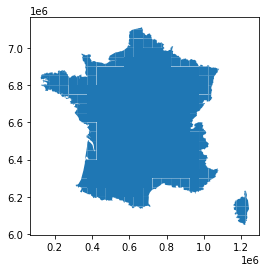

In [9]:
cells_geodf = reg.get_cells_geodf()
cells_geodf.plot()

In [10]:
places_geodf = data_access.return_json(places_files_paths[1])
places_geodf = geo.make_places_geodf(places_geodf, reg.shape_geodf, xy_proj=reg.xy_proj)

/home/thomaslouf/Documents/code/words-use/src/utils/geometry.py:236: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=places_geodf[['geometry']].centroid, crs=latlon_proj)


reminder: newly created GB cells geodf has GB index prefix, whereas previous data has UK prefix

In [11]:
places_geodf.sort_values(by='area').tail(10)

,attributes,country,country_code,full_name,name,place_type,url,min_lon,min_lat,max_lon,max_lat,geometry,area
place_id,,,,,,,,,,,,,
3da6b5ad7b0af478,{},France,FR,"Provence-Alpes-Côte d'Azur, France",Provence-Alpes-Côte d'Azur,admin,https://api.twitter.com/1.1/geo/id/3da6b5ad7b0...,4.227197,42.982218,7.719208,45.126494,"POLYGON ((800182.927 6209984.989, 796480.132 6...",4.759828e+10
8e0da10618d1836b,{},France,FR,"Champagne-Ardenne, France",Champagne-Ardenne,admin,https://api.twitter.com/1.1/geo/id/8e0da10618d...,3.383476,47.576559,5.890715,50.169192,"POLYGON ((728827.854 6719645.871, 727427.663 7...",4.760856e+10
60c859887b142d5f,{},France,FR,"Burgundy, France",Burgundy,admin,https://api.twitter.com/1.1/geo/id/60c859887b1...,2.844774,46.156060,5.518937,48.400155,"POLYGON ((688020.679 6561816.198, 688510.740 6...",5.038540e+10
8aee614456e63150,{},France,FR,"Languedoc-Roussillon, France",Languedoc-Roussillon,admin,https://api.twitter.com/1.1/geo/id/8aee614456e...,1.688810,42.332962,4.845444,44.975842,"POLYGON ((591761.776 6137890.214, 596639.244 6...",5.694997e+10
b86046fc346196ea,{},France,FR,"Pays de la Loire, France",Pays de la Loire,admin,https://api.twitter.com/1.1/geo/id/b86046fc346...,-2.559194,46.266641,0.916493,48.568090,"POLYGON ((272195.882 6589150.186, 290181.570 6...",6.136322e+10
807d76bc84f359c7,{},France,FR,"Centre, France",Centre,admin,https://api.twitter.com/1.1/geo/id/807d76bc84f...,0.052323,46.347028,3.128597,48.941078,"POLYGON ((473361.857 6587242.507, 484118.729 6...",6.655277e+10
771dd147cda1a16a,{},France,FR,"Rhône-Alpes, France",Rhône-Alpes,admin,https://api.twitter.com/1.1/geo/id/771dd147cda...,3.688350,44.115377,7.185481,46.519823,"POLYGON ((755097.483 6335392.677, 752769.531 6...",6.676023e+10
8e73e1421b45f5e8,{},France,FR,"Aquitaine, France",Aquitaine,admin,https://api.twitter.com/1.1/geo/id/8e73e1421b4...,-1.793003,42.777744,1.448288,45.714572,"POLYGON ((307565.595 6198382.192, 327360.296 6...",6.991998e+10
829cf2c4a7c5251d,{},France,FR,"Midi-Pyrénées, France",Midi-Pyrénées,admin,https://api.twitter.com/1.1/geo/id/829cf2c4a7c...,-0.327343,42.571641,3.451728,45.046506,"POLYGON ((426516.351 6169307.329, 438102.624 6...",7.859051e+10


In [40]:
for i, df_access in enumerate(data_access.yield_tweets_access(tweets_files_paths[0], size=1e9)):
    df = data_access.read_json_wrapper(df_access)
    break

ID English/Hindi code switching:

In [42]:
df.loc[(df['lang'] == 'en') & (df['text'].str.contains(r'\bbhi\b')), 'text'].values

array([], dtype=object)

ZA Swahili/English code switching:

In [20]:
df.loc[(df['lang'] == 'en') & (df['text'].str.contains(r'\bnje\b')), 'text'].values

array(['@0fe92a4e48a75713cdc4e60c28d0b0256af1f56d537dc7765ff40a19fe6a5eb246325a3a8a5447fd69eb77464c3bfe89fcc24c7e2a525ff904a554aef47ac74b see your life?? Amanga nje into yakho Smh',
       '@754d20fa496f3d263716d2332b35c46dc405f0f25652435a8a87d6bcf945b8f47582771a6bc852d1875dc98e4e6fa38310044cc2f48e81333b255d9b17bed3a0 its boring, its a hot normal day nje and what about urs?#HashmanAsks',
       "@f4d33e2f4415323a3863082434db72a98de2dfbbf01b49d6d3a7b0960c034c337152a443dd4356713520fc7ce78c5fff6a732c2ef9f48b177ad8da7bd24670c2 it's irritating... they just wanna empty our pockets really nje...",
       ...,
       'Why are the Americans still there??!!why dont they just walk away nje?',
       'Was just taking a walk nje..  #SomewhereOnEarth @ Constitution Hill (South Africa) https://t.co/7lHcv2ESG9',
       "Kune ndlela e right yokukhuza ingane ngeswazi.. Remember: you not fighting, you don't beat them, spanky spanky nje @e2e004b4d07755a06a638b0a3866fdb4d6e5aeaedc05d95bf2439097762f7fe9d34f

In [34]:
df.shape

(850370, 13)

In [12]:
df.join(places_geodf.loc[places_geodf['area'] < 1e10], on='place_id', how='inner').shape

(488413, 26)

<AxesSubplot:>

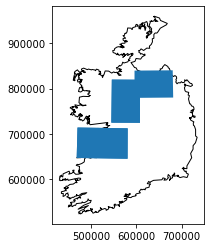

In [44]:
fig, ax = plt.subplots(1)
shape_geodf.plot(ax=ax, color='none', edgecolor='black')
places_in_xy.loc[(places_in_xy['area'] < 1e10) & (places_in_xy['area'] > 5e9)].plot(ax=ax)

# Process tweets

In [11]:
@ray.remote
def remote_chunk_process(df_access, cells_geodf, places_geodf, cells_in_places, lang):
    cols = ['text', 'source', 'coordinates', 'lang', 'place_id', 'uid']
    tweets_df = data_access.read_json_wrapper(df_access)[cols]
    cell_counts = word_counts.get_cell_word_counts(tweets_df, cells_geodf, places_geodf,
                                                   cells_in_places, lang)
    print('done')
    return cell_counts

In [12]:
@ray.remote(num_returns=2)
def get_places_and_intersect(places_fpath, shape_geodf, cells_geodf,
                             xy_proj='epsg:3857', max_place_area=5e9):
    places_geodf = data_access.return_json(places_fpath)
    # ext_loc = places_fpath.name.find('.json')
    # shape_geodf.cc = places_fpath[ext_loc-2: ext_loc]
    shape_geodf.cc = re.search(r'([A-Z]{2})', places_fpath.name).groups()[0]
    places_geodf = geo.make_places_geodf(places_geodf, shape_geodf, shape_geodf.cc,
                                         xy_proj=xy_proj)
    max_area_mask = places_geodf['area'] < max_place_area
    is_poi = places_geodf['area'] == 0
    relevant_bbox = max_area_mask & (~is_poi)
    cells_in_places = places_to_cells.get_intersect(
        cells_geodf, places_geodf.loc[relevant_bbox])
    return places_geodf, cells_in_places

In [ ]:
ray.init(num_cpus=num_cpus)
cell_counts_refs = []
raw_cell_counts_ref = []
for tweets_fpath, places_fpath in zip(tweets_files_paths, places_files_paths):
    print(tweets_fpath)
    places_geodf, cells_in_places = get_places_and_intersect.remote(
        places_fpath, shape_geodf, reg.cells_geodf,
        xy_proj=reg.xy_proj, max_place_area=reg.max_place_area)
    access_gen = data_access.yield_tweets_access(tweets_fpath, size=1e9)
    for i, df_access in enumerate(access_gen):
        cell_counts_refs.append(remote_chunk_process.remote(
            df_access, reg.cells_geodf, places_geodf, cells_in_places, reg.lang))
        ready, not_ready = ray.wait(cell_counts_refs, num_returns=len(cell_counts_refs), timeout=0.)
        if len(ready) > 2*num_cpus:
            print(f'combining {len(ready)} elements')
            comb_list = ray.get(ready) + raw_cell_counts_ref
            raw_cell_counts_ref = parallel.fast_combine(
                word_counts.combine_cell_counts, comb_list)
            for r in ready:
                cell_counts_refs.remove(r)

        if len(not_ready) > 1.5*num_cpus:
            print(f'waiting at iteration {i}, pending jobs: {len(not_ready)}')
            _, _ = ray.wait(not_ready, num_returns=1)
            print('waited')
    # To make it do something while loading large places data
    print(f'combining {len(ready)} elements')
    comb_list = ray.get(ready) + raw_cell_counts_ref
    raw_cell_counts_ref = parallel.fast_combine(
        word_counts.combine_cell_counts, comb_list)
    for r in ready:
        cell_counts_refs.remove(r)

In [ ]:
res = ray.get(cell_counts_refs)

In [ ]:
comb_list = res + raw_cell_counts_ref
raw_cell_counts_ref = parallel.fast_combine(word_counts.combine_cell_counts, comb_list)

In [18]:
reg.raw_cell_counts = ray.get(raw_cell_counts_ref)[0]
reg.raw_cell_counts.head()

count  ratio
word cell_id                     
A    GB.10     1056.246451    1.0
     GB.100   14376.024314    1.0
     GB.101   31576.796396    1.0
     GB.102    7601.272414    1.0
     GB.103   51118.622632    1.0

In [28]:
ray.shutdown()

# Aggregate counts

In [19]:
reg.region_counts = word_counts.get_reg_counts(reg.raw_cell_counts)
reg.region_counts.head()

,count,count_upper,nr_cells
word,,,
the,141066909,15052211,151.0
to,105794155,1943593,151.0
i,105521154,98455049,151.0
a,99599047,6155437,151.0
and,67443350,4560940,151.0


In [22]:
reg.raw_cell_counts = word_counts.agg_by_lower(reg.raw_cell_counts)
reg.raw_cell_counts.head()

count
word cell_id               
a    GB.10     16358.120571
     GB.100   217492.076747
     GB.101   480249.669315
     GB.102   120802.569295
     GB.103   911042.996403

In [23]:
reg.cell_counts, reg.region_counts = word_counts.filter_cell_counts(
    reg.raw_cell_counts, reg.region_counts, 
    upper_th=upper_th, 
    min_nr_cells=min_nr_cells)

Keeping 144 cells out of 151 with threshold 3.83e+04
We had 4315755638 tokens, and filtering brought it down to 3994813793, so we lost 7.44%.


In [24]:
reg.region_counts.head()

,count,count_upper,nr_cells,is_proper,nr_cell_mask
word,,,,,
the,141066909,15052211,151.0,False,True
to,105794155,1943593,151.0,False,True
i,105521154,98455049,151.0,True,True
a,99599047,6155437,151.0,False,True
and,67443350,4560940,151.0,False,True


In [26]:
reg.region_counts.to_parquet(str(paths.counts_files_fmt).format(kind='region_counts', lc=reg.lc, cc=reg.cc), index=True)

In [74]:
cc = 'US'
cnty_fname = 'cb_2018_us_county_5m'
state_fname = 'cb_2018_us_state_5m'
countries_dict['US']['cells_geodf'] = us_data.get_counties_geodf(
        cnty_fname, state_fname, paths.shp_file_fmt,
        xy_proj=countries_dict['US']['xy_proj'])
reg = Region.from_dict(cc, 'en', countries_dict[cc])

<AxesSubplot:>

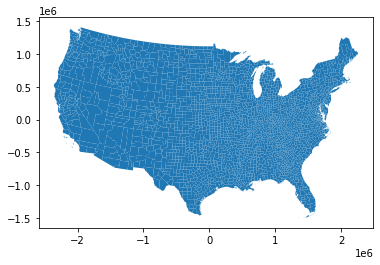

In [76]:
reg.cells_geodf.plot()

<AxesSubplot:>

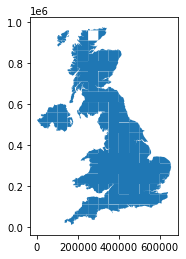

In [25]:
# cell_counts = pd.read_parquet(str(paths.counts_files_fmt).format('cell_counts', reg.lang, reg.cc))
reg.cells_geodf.loc[reg.cell_counts.index.levels[reg.cell_counts.index.names.index('cell_id')]].plot()

In [27]:
reg.raw_cell_counts.to_parquet(str(paths.counts_files_fmt).format(kind='raw_cell_counts', lc=reg.lc, cc=reg.cc), index=True)
reg.cell_counts.to_parquet(str(paths.counts_files_fmt).format(kind='cell_counts', lc=reg.lc, cc=reg.cc), index=True)

In [60]:
prior_mask = (~region_counts['is_proper']) & region_counts['nr_cell_mask']
cdf_mask = (region_counts.loc[prior_mask, 'count'] / region_counts.loc[prior_mask, 'count'].sum()).cumsum() < 0.99
mask = (cdf_mask & prior_mask).reindex(prior_mask.index)
word_vectors = word_counts.to_vectors(cell_counts, mask)
word_vectors = word_counts.vec_to_metric(word_vectors,
                                         region_counts.loc[mask],
                                         word_vec_var='polar')

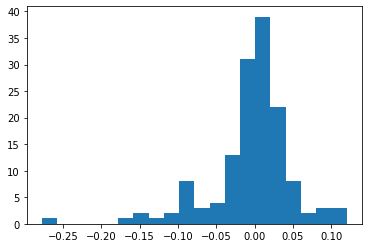

In [61]:
iloc_word = list(mask.loc[mask].index).index('have')
fig, ax = plt.subplots(1)
_, _, patches = ax.hist(word_vectors[:, iloc_word], bins=20)

# Moran

In [468]:
relevant_cells = reg.cell_counts.index.levels[reg.cell_counts.index.names.index('cell_id')]
contiguity = libpysal.weights.Queen.from_dataframe(reg.cells_geodf.loc[relevant_cells])
contiguity.transform = 'r'

In [469]:
num_cpus = 4
ray.init(num_cpus=num_cpus)
num_morans = word_vectors.shape[1]
shared_word_vectors = ray.put(word_vectors)
obj_refs = parallel.split_task(data_clustering.chunk_moran, num_cpus,
                               list(range(num_morans)), shared_word_vectors, contiguity)
res = ray.get(obj_refs)
moran_dict = res[0]
for m_dict in res[1:]:
    for key, value in m_dict.items():
        moran_dict[key].extend(value)

2021-02-26 15:27:45,352	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8266


In [413]:
reg.region_counts = reg.region_counts.join(pd.DataFrame.from_dict(moran_dict).set_index(reg.region_counts.loc[prior_mask].loc[cdf_mask].index[:num_morans]))

In [503]:
reg.region_counts.loc[(reg.region_counts['p_value'] < 0.01) & (reg.region_counts['z_value'] > 5)]

,count_upper,count,nr_cells,is_proper,nr_cell_mask,I,z_value,p_value
word,,,,,,,,
is,24125,437524,46,False,True,0.597490,6.261015,0.001
with,7623,227245,46,False,True,0.544524,5.616593,0.001
have,15796,190919,46,False,True,0.564684,5.917284,0.001
was,9365,186368,45,False,True,0.547882,5.671327,0.001
are,11073,180833,46,False,True,0.491163,5.135618,0.001
...,...,...,...,...,...,...,...,...
vocally,1,21,18,False,True,0.596515,6.514773,0.001
likeminded,0,21,21,False,True,0.439299,5.122707,0.002
moaners,1,21,23,False,True,0.456165,5.046692,0.001


In [506]:
reg.region_counts.to_parquet(str(paths.counts_files_fmt).format(kind='cell_counts', lc=reg.lang, cc=reg.cc), index=True)